In [10]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage, convert_to_openai_messages

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

### Retreival tool - basically same as we have been using.

In [11]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=text,
        model=model,
    )

    current_run = get_current_run_tree()

    if current_run:
        current_run.metadata["usage_metadata"] = {
            "input_tokens": response.usage.prompt_tokens,
            "total_tokens": response.usage.total_tokens
        }

    return response.data[0].embedding


@traceable(
    name="retrieve_data",
    run_type="retriever"
)
def retrieve_data(query, k=5):

    query_embedding = get_embedding(query)

    qdrant_client = QdrantClient(url="http://localhost:6333")

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    retrieved_context_ratings = []
    similarity_scores = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }


@traceable(
    name="format_retrieved_context",
    run_type="prompt"
)
def process_context(context):

    formatted_context = ""

    for id, chunk, rating in zip(context["retrieved_context_ids"], context["retrieved_context"], context["retrieved_context_ratings"]):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


def get_formatted_context(query: str, top_k: int = 5) -> str:

    """Get the top k context, each representing an inventory item for a given query.
    
    Args:
        query: The query to get the top k context for
        top_k: The number of context chunks to retrieve, works best with 5 or more
    
    Returns:
        A string of the top k context chunks with IDs and average ratings prepending each chunk, each representing an inventory item for a given query.
    """

    context = retrieve_data(query, top_k)
    formatted_context = process_context(context)

    return formatted_context

### State and Pydantic Models for structured outputs

In [12]:
class ToolCall(BaseModel):
    name: str
    arguments: dict

In [13]:
class RAGUsedContext(BaseModel):
    id: str = Field(description="ID of the item used to answer the question.")
    description: str = Field(description="Short description of the item used to answer the question.")

In [14]:
class AgentResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")
    references: list[RAGUsedContext] = Field(description="List of items used to answer the question.")
    final_answer: bool = False
    tool_calls: List[ToolCall] = []

In [15]:
class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    question_relevant: bool = False
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[ToolCall] = []
    final_answer: bool = False
    references: Annotated[List[RAGUsedContext], add] = []

### Agent Nodes

In [16]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def agent_node(state: State) -> dict:

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

    You will be given a conversation history and a list of tools you can use to answer the latest query.

    <Available tools>
    {{ available_tools | tojson }}
    </Available tools>

    When making tool calls, use this exact format:
    {
        "name": "tool_name",
        "arguments": {
            "parameter1": "value1",
            "parameter2": "value2",
        }
    }

    CRITICAL: All parameters must go inside the "arguments" object, not at the top level of the tool call.

    Examples:
    - Get formatted item context:
    {
        "name": "get_formatted_item_context",
        "arguments": {
            "query": "Kool kids toys.",
            "top_k": 5
        }
    }

    CRITICAL RULES:
    - If tool_calls has values, final_answer MUST be false
    (You cannot call tools and exit the graph in the same response)
    - If final_answer is true, tool_calls MUST be []
    (You must wait for tool results before exiting the graph)
    - If you need tool results before answering, set:
    tool_calls=[...], final_answer=false
    - After receiving tool results, you can then set:
    tool_calls=[], final_answer=true
    - Use names specificly provided in the available tools. Don't add any additional text to the names.

    Instructions:
    - You need to answer the question based on the outputs from the tools using the available tools only.
    - Do not suggest the same tool call more than once.
    - If the question can be decomposed into multiple sub-questions, suggest all of them.
    - If multiple tool calls can be used at once to answer the question, suggest all of them.
    - Do not explain your next steps in the answer, instead use tools to answer the question.
    - Never use word context and refer to it as the available products.
    - You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
    - As an output you need to return the following:

    * answer: The answer to the question based on your current knowledge and the tool results.
    * references: The list of the indexes from the chunks returned from all tool calls that were used to answer the question. If more than one chunk was used to compile the answer from a single tool call, be sure to return all of them.
    * Each reference should have an id and a short description of the item based on the retrieved context.
    * final_answer: True if you have all the information needed to provide a complete answer, False otherwise.

    - The answer to the question should contain detailed information about the product and should be returned with detailed specification in bullet points.
    - The short description should have the name of the item.
    - If the user's request requires using a tool, set tool_calls with the appropriate function names and arguments.
    """

   template = Template(prompt_template)
   
   prompt = template.render(
      available_tools=state.available_tools
   )

   messages = state.messages

   conversation = []

   for message in messages:
        conversation.append(convert_to_openai_messages(message))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5,
   )

   ai_message = format_ai_message(response)

   return {
      "messages": [ai_message],
      "tool_calls": response.tool_calls,
      "iteration": state.iteration + 1,
      "answer": response.answer,
      "final_answer": response.final_answer,
      "references": response.references
   }

#### Tool Router

In [17]:
def tool_router(state: State) -> str:
    """Decide whether to continue or end"""
    
    if state.final_answer:
        return "end"
    elif state.iteration > 2:
        return "end"
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"

#### Intent Router

In [ ]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    Instructions:
    - You will be given a conversation history with the user.
    - If the latest user messgae is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
    - If the latest user message is relevant, return True in field "question_relevant" and set "answer" to "".
    - You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.
    """

   template = Template(prompt_template)
   
   prompt = template.render()

   messages = state.messages

   conversation = []

   for message in messages:
        conversation.append(convert_to_openai_messages(message))

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5,
   )

   return {
      "question_relevant": response.question_relevant,
      "answer": response.answer
      }


In [19]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "agent_node"
    else:
        return "end"

In [ ]:
workflow = StateGraph(State)

tools = [get_formatted_context]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)
workflow.add_node("tool_node", tool_node)
workflow.add_node("intent_router_node", intent_router_node)

workflow.add_edge(START, "intent_router_node")

workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "agent_node": "agent_node",
        "end": END
    }
)

workflow.add_conditional_edges(
    "agent_node",
    tool_router,
    {
        "tools": "tool_node",
        "end": END
    }
)

# Why do we need this edge?
# This edge routes the flow from the 'tool_node' (where the tool output is computed) back to the 'agent_node',
# enabling the agent to use the results of tool calls to produce a final answer or potentially call more tools.
# It's essential in agent-tooling workflows where the agent needs to reason over new information or iterate on next actions.
workflow.add_edge("tool_node", "agent_node")

graph = workflow.compile()

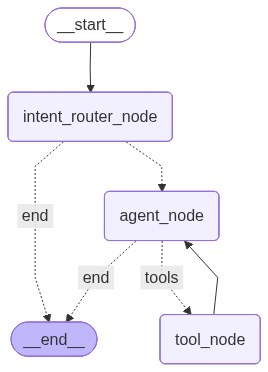

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
initial_state = {
    "messages": [{"role": "user", "content": "Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)

In [27]:
result

{'messages': [{'role': 'user',
   'content': 'Can I get earphones for myself, a laptop bag for my wife and something cool for my kids?'},
  AIMessage(content='I will look for earphones, a laptop bag, and something cool for kids from the available products.', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'get_formatted_context', 'args': {'query': 'earphones', 'top_k': 5}, 'id': 'call_0', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': 'laptop bag', 'top_k': 5}, 'id': 'call_1', 'type': 'tool_call'}, {'name': 'get_formatted_context', 'args': {'query': 'cool kids items', 'top_k': 5}, 'id': 'call_2', 'type': 'tool_call'}]),
  ToolMessage(content="- ID: B09VB5M3L5, rating: 4.3, description: Empsun Wired Earbuds Headphones with Microphone Stereo Bass Earphones Noise Isolation in-Ear Headset Compatible with All Smartphones Tablets iPod IPad MP3 Player That with 3.5 mm Interface(Black) . [In-line microphone]: With in-line microphone can conveninet to

In [28]:
print(result["answer"])

For earphones, there are several options:
- Empsun Wired Earbuds Headphones with Microphone, Stereo Bass, Noise Isolation, compatible with all smartphones and devices with 3.5mm interface. Features include in-line microphone, comfortable ergonomic design, balanced stereo bass audio, and wide compatibility. It comes with 12-month hassle-free protection.
- HeGaalah Open Ear Bone Conduction Headphones with Bluetooth 5.3, waterproof, clip-on design.
- ZTOZ Wireless Earbuds Bluetooth 5.0 with immersive bass sound, mini charging case, waterproof, touch control, 30 hours playtime, ergonomic design, ENC noise cancellation, and one-step pairing.

For laptop bags suitable for your wife:
- KIZUNA Laptop Bag Case 14 Inch, water-resistant, shoulder sleeve, compatible with various 14" laptops, ultra-protection with thick cushioning, and easy to carry with shoulder strap and trolley belt.
- DOMISO 17.3 inch Laptop Sleeve Case, water-resistant, shockproof, with extra storage space and durable handle.


In [24]:
initial_state = {
    "messages": [{"role": "user", "content": "Can you fix my roof?"}],
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)
print(result["answer"])

Your question is not relevant to the products in stock. I can assist you with questions about products available for purchase.
